# Day 3 – Feature Engineering
Today, we explore what happens when one input isn't enough or when the relationship isn't strictly linear.

Today, we'll see what happens when one input isn't enough or when a relationship isn't a straight line. This notebook demonstrates how to build a multiple linear regression model to use several predictors at once, and then how to use polynomial terms to capture curved patterns in the data.

## Load the Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Load data
mission_df = pd.read_csv("/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/mission_data.csv")
mission_df.head()


,mission_id,mission_type,crew_size,mission_duration_days,distance_to_target_km,fuel_capacity_kg,payload_mass_kg,mental_health_score,solar_flare_risk,mission_cost_millions,anomaly_detected,mission_success_score,mission_outcome
0,MSN_0000,Exploration,9,1173.0,459.67,1188.05,725.61,0.640,0.319,254.79,0,80.82,Success
1,MSN_0001,Resupply,6,1059.0,434.02,1066.20,618.12,NaN,0.235,161.03,0,93.81,Success
2,MSN_0002,Exploration,7,1464.7,596.50,1411.42,810.49,0.767,0.045,261.06,0,91.95,Success
3,MSN_0003,Rescue,9,1833.2,734.71,1895.24,1220.50,0.791,0.199,574.26,0,82.80,Success
4,MSN_0004,Exploration,5,1678.2,680.75,1535.50,927.37,0.874,0.375,290.14,0,87.37,Success


## Part 1. Multilinear Regression (Mission Duration Prediction Example)

Goal: Predict fuel capacity based on

`distance_to_target_km`

`mission_duration_days`

These features were chosen because longer missions and farther distances are likely to require more fuel.


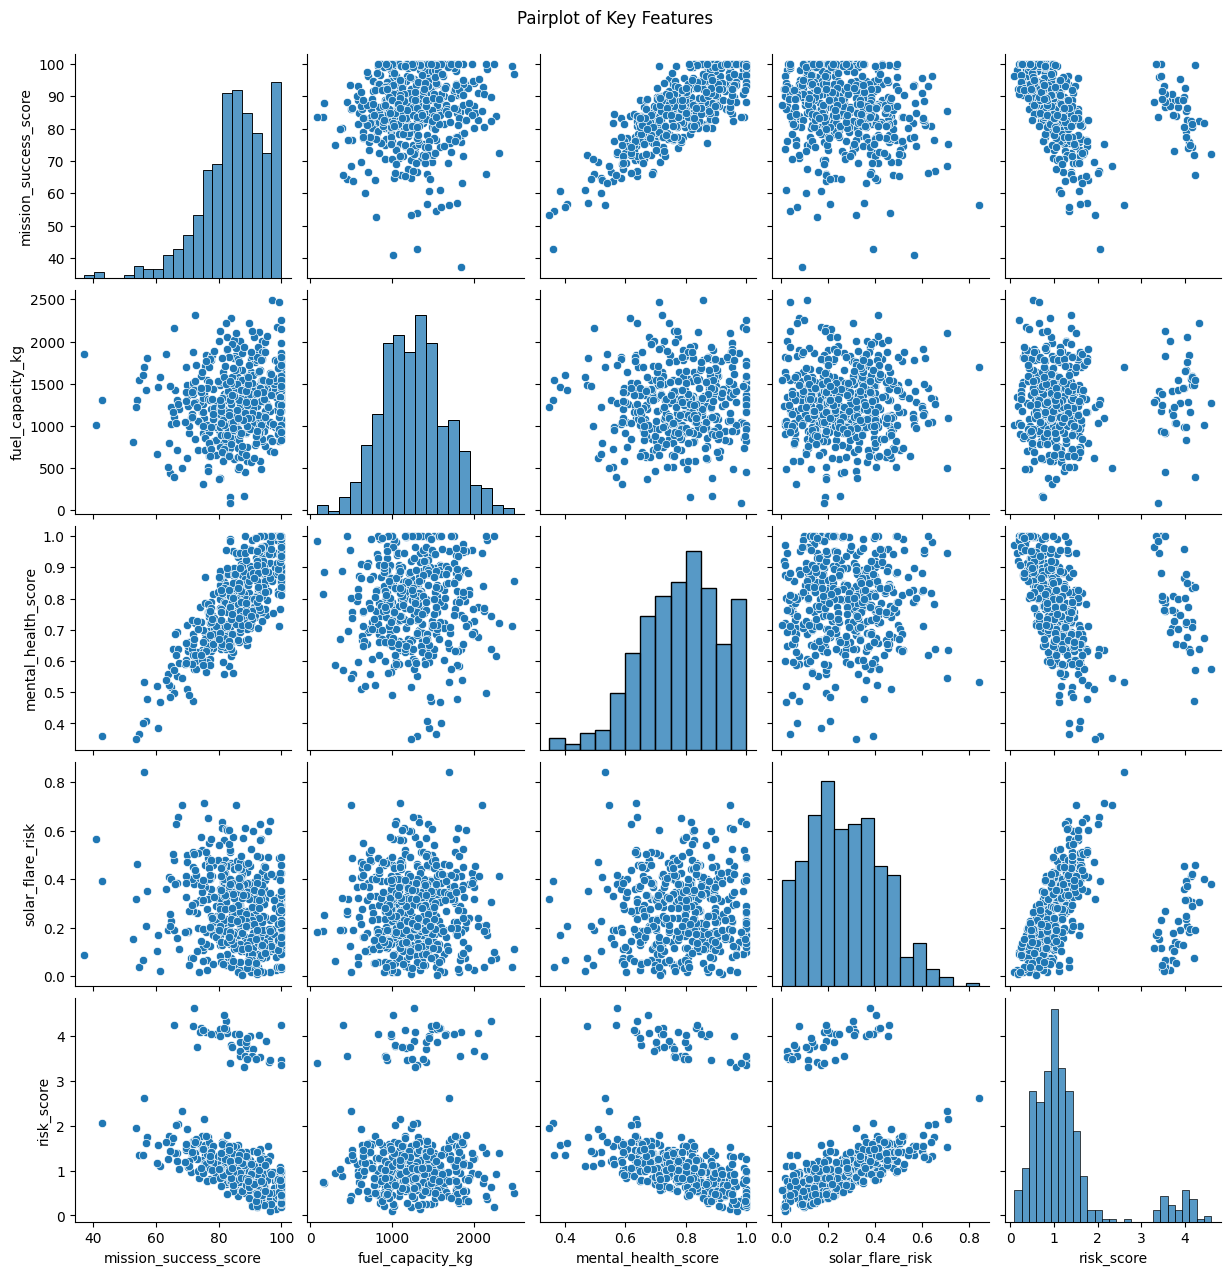

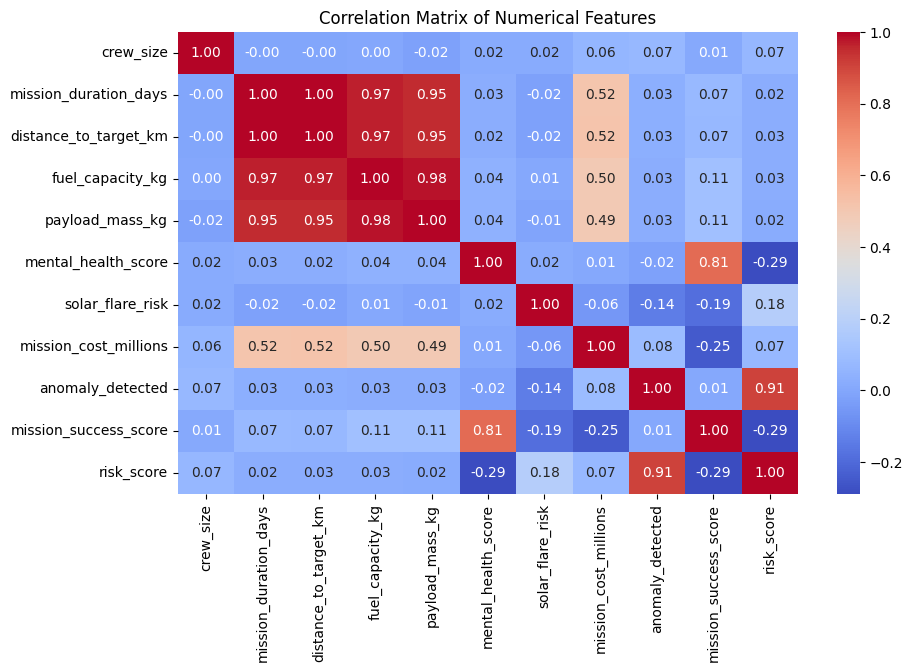

,mission_id,crew_size,mission_duration_days,distance_to_target_km,fuel_capacity_kg,payload_mass_kg,mental_health_score,solar_flare_risk,mission_cost_millions,anomaly_detected,mission_success_score,mission_outcome,risk_score,mission_type_Rescue,mission_type_Resupply,duration_bin_medium,duration_bin_long
0,MSN_0000,1.503600,1173.0,-0.343316,-0.200878,725.61,-1.073660,0.281751,254.79,0,80.82,Success,0.078337,False,False,False,True
1,MSN_0001,0.022707,1059.0,-0.502785,-0.502699,618.12,NaN,-0.261995,161.03,0,93.81,Success,NaN,False,True,False,True
2,MSN_0002,0.516338,1464.7,0.507377,0.352408,810.49,-0.116724,-1.491897,261.06,0,91.95,Success,-0.766356,False,False,False,True
3,MSN_0003,1.503600,1833.2,1.366649,1.550826,1220.50,0.064114,-0.495029,574.26,0,82.80,Success,-0.492516,True,False,False,True
4,MSN_0004,-0.470924,1678.2,1.031171,0.659753,927.37,0.689513,0.644249,290.14,0,87.37,Success,-0.296614,False,False,False,True


In [9]:
# Binning mission durations
mission_df["duration_bin"] = pd.cut(
    mission_df["mission_duration_days"],
    bins=[0, 250, 750, np.inf],
    labels=["short", "medium", "long"]
)

# Risk score: combines flare risk, anomaly presence, and low mental health
mission_df["risk_score"] = (
    mission_df["solar_flare_risk"] * 2 +
    mission_df["anomaly_detected"] * 3 +
    (1 - mission_df["mental_health_score"]) * 2
)

# One-hot encode the 'mission_type' and 'duration_bin'
df_encoded = pd.get_dummies(mission_df, columns=["mission_type", "duration_bin"], drop_first=True)

# Normalize numeric features
numeric_cols = [
    "crew_size", "distance_to_target_km", "fuel_capacity_kg", "solar_flare_risk",
    "mental_health_score", "risk_score"
]
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# Save cleaned and engineered dataset for future use
df_encoded.to_csv("/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/encoded_data", index=False)

# Pairplot of engineered features
sns.pairplot(mission_df[[
    "mission_success_score", "fuel_capacity_kg", "mental_health_score",
    "solar_flare_risk", "risk_score"
]])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mission_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Display sample of engineered DataFrame
df_encoded.head()


### What This Tells Us

| Model Type          | Target                | Key Insight                                          | R² Score |
| :------------------ | :-------------------- | :--------------------------------------------------- | :------- |
| **Multi-Linear** | `fuel_capacity_kg`    | Using multiple features gives a highly accurate model. | 0.941    |
| **Polynomial** | `health_impact_score` | A nonlinear relationship fits real-world patterns better. | 0.940    |


### Takeaways

- **Multiple Linear Regression** allows us to capture interactions between features. We explained over 94% of the variation in fuel needs — a major improvement over simple linear models.

- **Polynomial Regression** offers powerful flexibility when a simple line isn’t enough. The quadratic fit closely matched a simulated nonlinear relationship.

- **Low MSE and RMSE** values confirm that our models are both accurate and stable.

⚠️ **Caution:** More complexity isn’t always better. Polynomial terms can cause overfitting if not used carefully.

**Interpretability:** With linear models, coefficients are easy to interpret. With polynomial models, they’re less intuitive but still reveal useful curvature trends.

📌 Next up: **Day 3 – Feature Engineering & Multilinear Modeling Techniques**
